In [3]:
import numpy as np
import emcee 
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [ ]:
data = ascii.read('/Users/iraf1/Downloads/dd') # load data

## Section 1.1 - Quality Cuts
 - Remove NaN values [what age index are the nans]
 - $J_R$/$J_{R_{err}}$ > 20 ( or if this doesn't work -- parallax > 0.5 ) 
 - $J_R$ < 1500 -- looks like some stars have big action values that may be outliers
 - Dist > 0.5 (there seems to be an error with the distance estimate) 




## Section 1.2 - Population Cuts 
 - __Red Giants__: $log(g)$ < 3.8 dex 
 - __Main Sequence__: $log(g)$ > 3.8 dex
 
 


notes: 
 - Jz <1 : will restrict us to the disk 

OR

 - |Z| < 2 : will restrict the search to disk stars


In [3]:
# Define variables from Astropy table 

feh = data['fe_h'] # metalicity 
e_feh = data['e_fe_h']
l, b = data['l'], data['b'] # coordinates in Galactic

jr = data['JR'] # radial action
jr_err = data['JR_err'] # radial action error 

log_g = data['logg_1']
teff = data['teff']
parallax = data['parallax']
log_age = data['log_age']
age = 10**(log_age)
dist = data['dist']
mass = data['mass'] # APOGEE
mu_l , mu_b = data['mu_l'], data['mu_b']
z = data['z']



# Quality cuts to ensure quality of data : NOTE parallax < 0.5 (2kpc limit!)
qc = np.where((jr/jr_err > 20) & (jr<1500) & (age>0.5) & (age != np.ma.core.MaskedConstant()) & (feh != np.ma.core.MaskedConstant()) & (jr != np.ma.core.MaskedConstant()))

feh, e_feh, l, b = feh[qc], e_feh[qc], l[qc], b[qc]
jr, jr_err, log_g, teff, parallax, log_age, dist, mass = jr[qc], jr_err[qc], log_g[qc], teff[qc], parallax[qc], log_age[qc], dist[qc], mass[qc]
mu_l, mu_b, age  = mu_l[qc], mu_b[qc], age[qc]
z = z[qc]

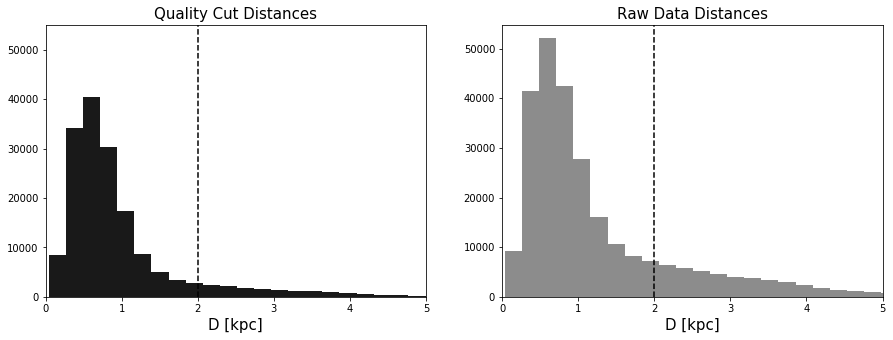

In [4]:
plt.figure(figsize=(15,11))
plt.subplot(221)
plt.hist(dist, bins=100, normed=False, color='k', alpha=0.9)
plt.xlim(0,5)
plt.ylim(0,55000)
plt.title('Quality Cut Distances', size=15)
plt.xlabel('D [kpc]', size=15)
plt.axvline(2, color='k', ls='--')

plt.subplot(222)
plt.hist(data['dist'], bins=100, normed=False, color='gray', alpha=0.9, ls='--', histtype='stepfilled')
plt.xlim(0,5)
plt.title('Raw Data Distances', size=15)
plt.xlabel('D [kpc]', size=15)
plt.axvline(2, color='k', ls='--')


/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


Number of stars in MS cut: 117463
Number of stars in RG cut: 48676


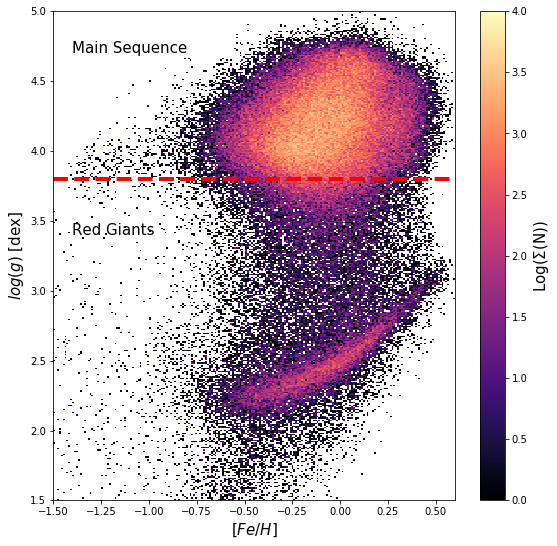

In [5]:
cut_off = 3.8 # 3.8 sugggested by literatyre
# Apply population cuts
MS = np.where(log_g > cut_off)
RG = np.where(log_g < cut_off)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))

g_hist = np.histogram2d(log_g, feh, bins=(np.arange(1.5,5,0.01), np.arange(-1.5, 0.6, 0.01)))

Z = ax.imshow(np.log(g_hist[0]), aspect='auto', origin='lower', interpolation='nearest',
            extent=[-1.5, 0.6, 1.5, 5], cmap='magma', vmin=0, vmax=4)
ax.axhline(cut_off, color='red', ls='--', lw=4)

ax.text(-1.4,3.4, 'Red Giants', size=15, color='k' )
ax.text(-1.4,4.7, 'Main Sequence', size=15, color='k' )

ax.set_xlabel('$[Fe/H]$', size=15)
ax.set_ylabel('$log(g)$ [dex]', size=15)
cbar = fig.colorbar(Z)#, label='$Log(\Sigma(N))$')
cbar.ax.set_ylabel('Log($\Sigma$(N))', fontsize=15)

print ("Number of stars in MS cut: %d" %len(MS[0]))
print ("Number of stars in RG cut: %d" %len(RG[0]))

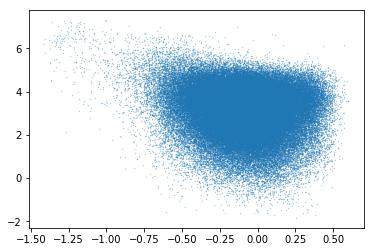

In [9]:
plt.scatter(feh[MS], np.log(jr[MS]), s=0.1, alpha=0.5)

Text(0.5,1,'Red Giants')

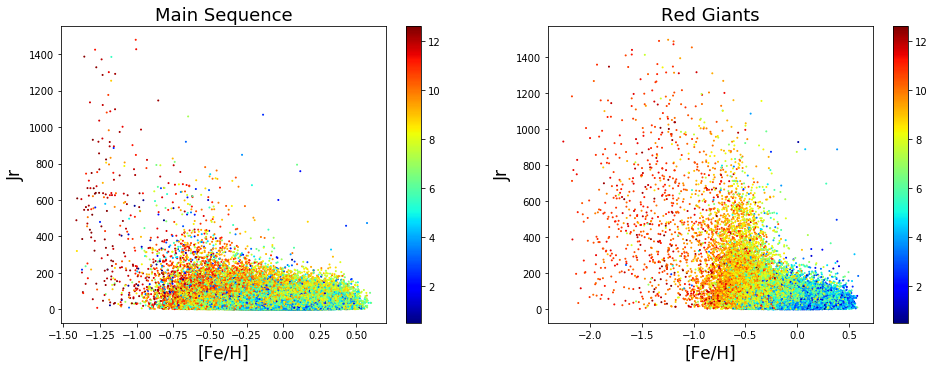

In [599]:
plt.figure(figsize=(16,12))

plt.subplot(221)
plt.scatter(feh[MS], jr[MS],c=age[MS], s=1, alpha=1, cmap='jet')
#plt.ylim(0,250)
#plt.xlim(-0.65)
plt.xlabel('[Fe/H]', size=17)
plt.ylabel('Jr', size=17)
plt.colorbar()
plt.title('Main Sequence', size=18)

plt.subplot(222)
plt.scatter(feh[RG], jr[RG],c=age[RG], s=1, alpha=1, cmap='jet')
#plt.ylim(0,450)
#plt.xlim(-0.65)
plt.xlabel('[Fe/H]', size=17)
plt.ylabel('Jr', size=17)
plt.colorbar()
plt.title('Red Giants', size=18)



In [600]:

df_ms  = stats.binned_statistic_2d(jr[MS], feh[MS], age[MS], statistic='median',
                                   bins=(np.arange(0, 600, 25), np.arange(-1, 0.6, 0.1)))

df_rg  = stats.binned_statistic_2d(jr[RG], feh[RG], age[RG], statistic='median',
                              bins=(np.arange(0, 800, 25), np.arange(-1.5, 0.6, 0.1)))

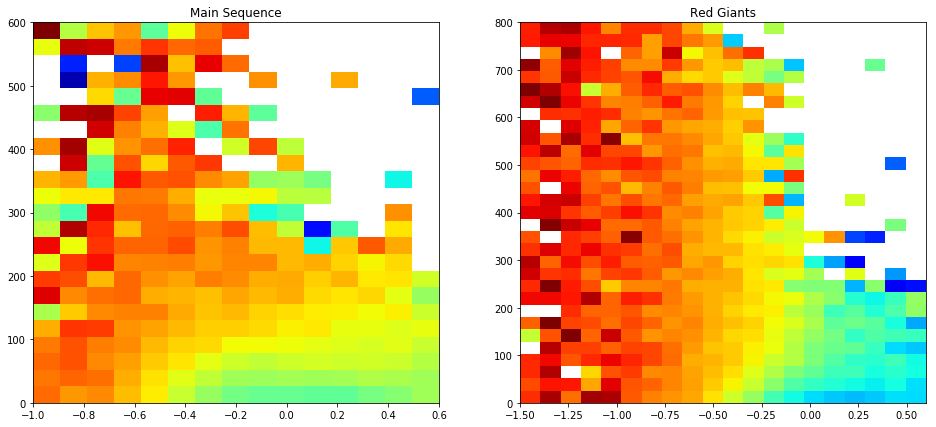

In [601]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

ax2 = ax[0].imshow((df_ms[0]), aspect='auto', origin='lower', cmap='jet',
          vmin=0, vmax=12, extent=[-1, 0.6, 0, 600])
ax[0].set_title('Main Sequence')


ax1 =  ax[1].imshow((df_rg[0]), aspect='auto', origin='lower', cmap='jet',
          vmin=0, vmax=12, extent=[-1.5, 0.6, 0, 800])
ax[1].set_title('Red Giants')

A = np.array([ax1, ax2])



/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'[Fe/H]')

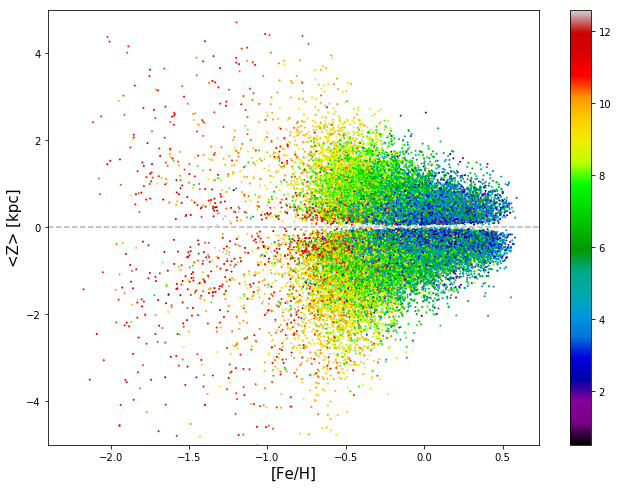

In [602]:
plt.figure(figsize=(11,8))
plt.scatter(feh[RG], z[RG], c=age[RG], cmap='spectral', s=1)
plt.colorbar()
plt.ylim(-5,5)
plt.axhline(0, color='k', ls='--', alpha=0.3)
plt.ylabel('<Z> [kpc]', size=15)
plt.xlabel('[Fe/H]', size=15)

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'[Fe/H]')

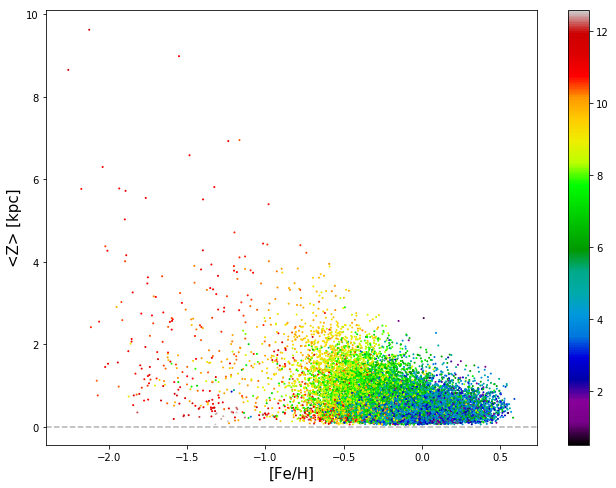

In [608]:
plt.figure(figsize=(11,8))
plt.scatter((feh[RG])[z[RG]>0], (z[RG])[z[RG]>0], c=(age[RG])[z[RG]>0], cmap='spectral', s=1)
plt.colorbar()
#plt.ylim(-5,5)
plt.axhline(0, color='k', ls='--', alpha=0.3)
plt.ylabel('<Z> [kpc]', size=15)
plt.xlabel('[Fe/H]', size=15)

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'[Fe/H]')

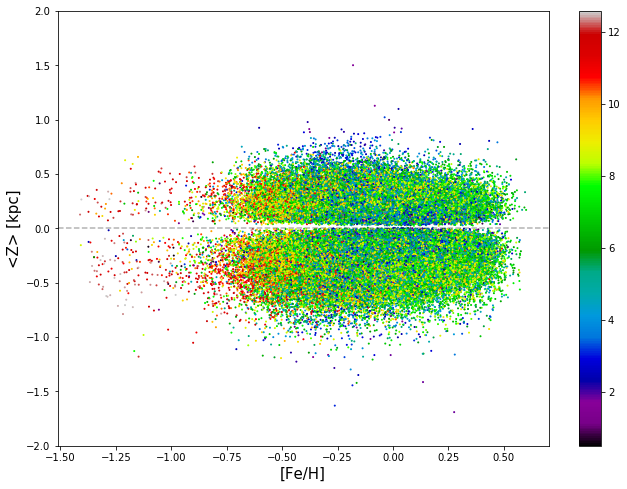

In [603]:
plt.figure(figsize=(11,8))
plt.scatter(feh[MS], z[MS], c=age[MS], cmap='spectral', s=1)
plt.colorbar()
plt.ylim(-2,2)
plt.axhline(0, color='k', ls='--', alpha=0.3)
plt.ylabel('<Z> [kpc]', size=15)
plt.xlabel('[Fe/H]', size=15)